In [1]:
import lightkurve as lk

In [3]:
search = lk.search_lightcurve("Beta Pictoris", mission="TESS")
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,SPOC,120,270577175,0.0
1,TESS Sector 04,2018,TESS-SPOC,1800,270577175,0.0
2,TESS Sector 04,2018,QLP,1800,270577175,0.0
3,TESS Sector 05,2018,SPOC,120,270577175,0.0
4,TESS Sector 05,2018,TESS-SPOC,1800,270577175,0.0
5,TESS Sector 05,2018,QLP,1800,270577175,0.0
6,TESS Sector 06,2018,SPOC,120,270577175,0.0
7,TESS Sector 06,2018,TESS-SPOC,1800,270577175,0.0
8,TESS Sector 06,2018,QLP,1800,270577175,0.0


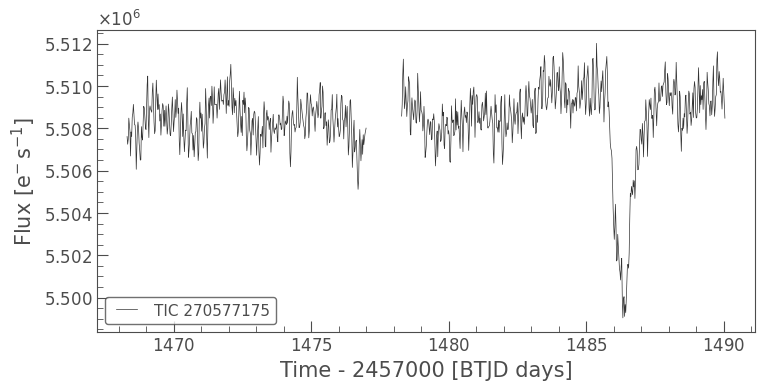

In [9]:
tlc = search[7].download()
tlc.plot()

In [10]:
tlc.columns

<TableColumns names=('time','flux','flux_err','timecorr','cadenceno','centroid_col','centroid_row','sap_flux','sap_flux_err','sap_bkg','sap_bkg_err','pdcsap_flux','pdcsap_flux_err','quality','psf_centr1','psf_centr1_err','psf_centr2','psf_centr2_err','mom_centr1','mom_centr1_err','mom_centr2','mom_centr2_err','pos_corr1','pos_corr2')>